# Intro to Deep Learning 
## Neural Networks 

Start with Slide Show 
First we import some libraries: 

    keras.datasets mnist: The MNIST data set provided from Keras 
    matplotlib.pyplot: Visualization tool for observing the data
    numpy: Mathematical Library that we will use to build a neural network from scratch
    keras.layers, models, optimmizers: Keras library is built for making NN quick and easily 
    sklearn: Welld eveloped ML tool kit for data manipulation 
    pandas: a Dataframe library that caan be used for sattistical evaluations and organizing big data

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop, Adadelta, Adam, SGD
from sklearn.model_selection import train_test_split
import pandas as pd

Using TensorFlow backend.


Now we are going to observe a common data set used for learning NN. 
The MNIST data set is a large data base of images of handwritten digits, with a corresponding label. 
We will load the data an observe a random example from out training set. 

Data Shape: (60000, 28, 28)
Target Shape: (60000,)
Picture of 0


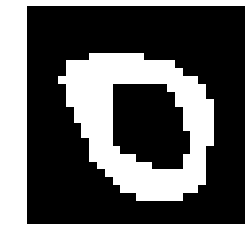

In [2]:
(o_x_train, o_y_train), (o_x_test, o_y_test) = mnist.load_data()

i = np.random.randint(0,o_x_train.shape[0])
print('Data Shape: ' + str(o_x_train.shape))
print('Target Shape: ' + str(o_y_train.shape))
print('Picture of ' + str(o_y_train[i]))
plt.imshow(o_x_train[i], cmap='gray')
plt.axis('off')
plt.show()

### 1) Pre-Processing Data

At the beginning of every experiment, we split the training data into training and validation

In [3]:
x_train, x_val, y_train, y_val = train_test_split(o_x_train, o_y_train,
                                                  test_size=0.1,
                                                  random_state=20)
print('The Training set images have this shape: ' + str(x_train.shape))
print('The Training set labels have this shape: ' + str(y_train.shape))
print('The Validation set images have this shape: ' + str(x_val.shape))
print('The Validation set labels have this shape: ' + str(y_val.shape))

The Training set images have this shape: (54000, 28, 28)
The Training set labels have this shape: (54000,)
The Validation set images have this shape: (6000, 28, 28)
The Validation set labels have this shape: (6000,)


Before we start with the NN, we need to take our images os (28x28) pxels and flatten them into one dimensional vectors for the input. And we need to categorize the labels into a vector of zeros and ones to train the output. 

In [4]:
y_train_targ = pd.get_dummies(y_train)
y_val_targ = pd.get_dummies(y_val)

x_train = x_train.reshape(x_train.shape[0],
                          x_train.shape[1]*x_train.shape[2] )

x_val = x_val.reshape(x_val.shape[0],
                      x_val.shape[1] * x_val.shape[2])
print('The Training set images have this shape: ' + str(x_train.shape))
print('The Training set labels have this shape: ' + str(y_train_targ.shape))
print('The Validation set images have this shape: ' + str(x_val.shape))
print('The Validation set labels have this shape: ' + str(y_val_targ.shape))

The Training set images have this shape: (54000, 784)
The Training set labels have this shape: (54000, 10)
The Validation set images have this shape: (6000, 784)
The Validation set labels have this shape: (6000, 10)


### 2) Building a NN the EASY way 


We will use keras which is the most popular library right now for developing NNs. 

This model has an input of the dimension of our data (784) and an output of (10)

In [5]:
model = Sequential()
model.add(Dense(1568, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(1568, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1568)              1230880   
_________________________________________________________________
dense_2 (Dense)              (None, 1568)              2460192   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                15690     
Total params: 3,706,762
Trainable params: 3,706,762
Non-trainable params: 0
_________________________________________________________________


### 3) Training

Next we train the model using the keras fit function. Then at the end we can evaluate the model on the validation set. 


In [8]:
model.fit(x_train, y_train_targ.values, epochs=1, batch_size=x_train.shape[0])


scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

Epoch 1/1
6000/6000 [==============================] - 2s 269us/step

categorical_accuracy: 11.12%


And Congradulations! You've built your first neural network. 


## Neural Networks from scratch 

To better understand the keras model that we just built, we will delve into building a neural network from scratch using Numpy.

Here we are going to use some object oriented programming. The basicNN will be our class that will be built of our model. So we are going to go through this slowly. 

BUT!! Before we can build the class we need some pieces built first.

In [9]:
# Sigmoid function is going to be the output of our hidden layers. Output Domain: [-1, 1]
def sigmoid(s):
    return 1/(1 + np.exp(-s))

# Softmax will be the activation function for the output. Output Domain: [0,1]
def softmax(s):
    exps = np.exp(s-np.max(s,axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

# For backpropagation algorithm,, we will need the derivative of our activation functions to update the weights. 
# therefore this is the derivative of the Sigmoid function withr espect to it's input 
def dSigmoid_ds(s):
    return (1-sigmoid(s))*sigmoid(s)

# This is our loss function. We will use cross entropy as we did in the keras model 
def cross_entropy(pred, true):
    n_samples = true.shape[0]
    res = pred - true
    return res/n_samples

# And finally we need a way to quantify the error. 
# This will take a predicted vecctor and ground truth vector and determine how correct the prediction is. 
def error(pred, true):
    n_samples = true.shape[0]
    logp = -np.log(pred[np.arange(n_samples), true.argmax(axis=1)])
    loss = np.sum(logp)/(n_samples)
    return loss

In [10]:
np.random.seed(0)
class BasicNN:
    def __init__(self, x, y):
        ''' 
        This is the initializer for the class. 
        All we need as input for the initialization is the training data and the labels 
        '''
        self.x = x
        self.y = y
        # Now we can declare how large we want the hidden layers to be. 
        # Lets keep the same structure as above 
        neurons = 1568
        
        # Then we need to decide on a learning rate. In the Keras SGD optimizer, this is 0.01
        self.lr = 0.01
        
        # We will declare variables of the input and output shape
        ip_dim = x.shape[1]
        op_dim = y.shape[1]

        # Finally we decide to Declare Weights and biases usign a random number generator 
        # wi is a matrix
        # bi is a vector

        self.w1 = np.random.randn(ip_dim, neurons)
        self.b1 = np.zeros((1, neurons))

        self.w2 = np.random.randn(neurons, neurons)
        self.b2 = np.zeros((1, neurons))

        self.w3 = np.random.randn(neurons, op_dim)
        self.b3 = np.zeros((1,op_dim))

    def feedforward(self):
        '''
        Feeds forward the data
        This function will run a sample from the beginning to the end and give us our out put. 
        Remember we are going to want to save the activation of these examples so we can evaluate the gradient
        and back propogate the error to update the weights
        :return:
        '''
        ### First Layer
        z1 = np.dot(self.x, self.w1) + self.b1
        self.a1 = sigmoid(z1)
        ### Second Layer
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(z2)
        ### Third Layer
        z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = softmax(z3)

    def backprop(self):
        '''
        Back propogates the error to update the waits.
        This evaluates the error and the propogates the error through the layers that we built in the 
        initializer. 
        '''
        # evaluate loss
        loss = error(self.a3, self.y)

        print('Error: ')
        print(loss)
        
        # Find the derivative values using the chain rule 
        d_a3 = cross_entropy(self.a3, self.y)
        d_z2 = np.dot(d_a3, self.w3.T)
        d_a2 = d_z2 * dSigmoid_ds(self.a2)
        d_z1 = np.dot(d_a2, self.w2.T)
        d_a1 = d_z1 * dSigmoid_ds(self.a1)
        
        # Now update the weights and biases 
        self.w3 -= self.lr * np.dot(self.a2.T, d_a3)
        self.b3 -= self.lr * np.sum(d_a3, axis = 0, keepdims=True)

        self.w2 -= self.lr * np.dot(self.a1.T, d_a2)
        self.b2 -= self.lr * np.sum(d_a2, axis=0, keepdims=True)

        self.w1 -= self.lr * np.dot(self.x.T, d_a1)
        self.b1 -= self.lr * np.sum(d_a1, axis=0, keepdims=True)

    def predict(self, data):
        '''
        Finally, in the end we will want our NN to be able to predict on a given test subject. 
        Therefore, this functino predicts and returns the answer. 
        '''
        self.x = data
        self.feedforward()
        return self.a3.argmax(axis=1)

Now Training becomes very different because wee need to control the NN differently than wee did in Keras. 

In [11]:
basic_model = BasicNN(x_train, y_train_targ.values)
# Let's use the same amount of epochs as before. 
epochs = 1
for i in range(epochs):
    print('Epoch: ' + str(i))
    basic_model.feedforward()
    basic_model.backprop()

pred = basic_model.predict(x_val)

acc = 0
for i in range(pred.shape[0]):
    if pred[i] == y_val_targ.values.argmax(axis=1)[i]:
        acc += 1

print('Homemade NN Accuracy is: ' + str(acc/y_val_targ.values.shape[0]*100))

Epoch: 0


C:\Users\rotation\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Error: 
45.027894042362384
Homemade NN Accuracy is: 23.599999999999998


And this gives us an accuracy for the Homemade NN on the same data we used with the Keras model. 

## Epoches and Mini-Batches

Let's test them out using more than one epoch. 

In [12]:
model = Sequential()
model.add(Dense(1568, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(1568, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(x_train, y_train_targ.values, epochs=10, batch_size=x_train.shape[0])


scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

basic_model = BasicNN(x_train, y_train_targ.values)
# Let's use the same amount of epochs as before. 
epochs = 10
for i in range(epochs):
    print('Epoch: ' + str(i))
    basic_model.feedforward()
    basic_model.backprop()

pred = basic_model.predict(x_val)

acc = 0
for i in range(pred.shape[0]):
    if pred[i] == y_val_targ.values.argmax(axis=1)[i]:
        acc += 1

print('Homemade NN Accuracy is: ' + str(acc/y_val_targ.values.shape[0]*100))

Epoch 1/10
54000/54000 [==============================] - 14s 256us/step - loss: 2.4305 - categorical_accuracy: 0.1162
Epoch 2/10
54000/54000 [==============================] - 14s 258us/step - loss: 2.3464 - categorical_accuracy: 0.1249
Epoch 3/10
54000/54000 [==============================] - 13s 248us/step - loss: 2.3053 - categorical_accuracy: 0.1479
Epoch 4/10
54000/54000 [==============================] - 13s 247us/step - loss: 2.2813 - categorical_accuracy: 0.1760
Epoch 5/10
54000/54000 [==============================] - 15s 280us/step - loss: 2.2652 - categorical_accuracy: 0.1944
Epoch 6/10
54000/54000 [==============================] - 17s 322us/step - loss: 2.2528 - categorical_accuracy: 0.2122
Epoch 7/10
54000/54000 [==============================] - 15s 270us/step - loss: 2.2422 - categorical_accuracy: 0.2312
Epoch 8/10
54000/54000 [==============================] - 14s 256us/step - loss: 2.2324 - categorical_accuracy: 0.2494
Epoch 9/10
54000/54000 [========================

C:\Users\rotation\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Error: 
36.37114978638717
Epoch: 1
Error: 
61.60994194563323
Epoch: 2
Error: 
59.94887222393052
Epoch: 3
Error: 
78.62141100885326
Epoch: 4
Error: 
73.84099124490432
Epoch: 5
Error: 
77.33667005797453
Epoch: 6
Error: 
80.73445015978126
Epoch: 7
Error: 
61.606020691968155
Epoch: 8
Error: 
45.218076598535774
Epoch: 9
Error: 
42.464619720084826
Homemade NN Accuracy is: 53.93333333333333


So as you can see, When we increase the Epochs, the Networks get more accurate at predictiing which number it is looking at. 

Now let's introduce a new concept to the training. Mini-batches. Instead of updating the weights every epoch, a quicker and more efficient way to train is to update the weights multiple times during an epoch. Our Homemade NN unfortunately is not coded to use mini-batches, therefore we will illustrate this using our Keras model. 


In [13]:
model = Sequential()
model.add(Dense(1568, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(1568, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(x_train, y_train_targ.values, epochs=10, batch_size=int(x_train.shape[0]/100))


scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1568)              1230880   
_________________________________________________________________
dense_5 (Dense)              (None, 1568)              2460192   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                15690     
Total params: 3,706,762
Trainable params: 3,706,762
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
54000/54000 [==============================] - 17s 314us/step - loss: 1.9410 - categorical_accuracy: 0.5436
Epoch 2/10
54000/54000 [==============================] - 19s 348us/step - loss: 1.3383 - categorical_accuracy: 0.7911
Epoch 3/10
54000/54000 [==============================] - 18s 328us/step - loss: 0.9937 - categorical_accuracy: 0.8343
Epoch 4/10
54000/54000 [===============

And This turns out to give the best accuracy out of all the models we've built here. 

## Convolutional Neural Networks 

Just like we discussed in lecture, their is a posibility of not flattening your images and actually using convolutional filter layers to learn features in the image, which better assists in image recognition. Therefore, we will build a CNN with the MNIST data set here. Let's start with a new preprocessing step. 

In [6]:
(o_x_train, o_y_train), (o_x_test, o_y_test) = mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(o_x_train, o_y_train,
                                                  test_size=0.1,
                                                  random_state=20)

y_train_targ = pd.get_dummies(y_train)
y_val_targ = pd.get_dummies(y_val)

x_train = x_train[:,:,:,np.newaxis]
x_val = x_val[:,:,:,np.newaxis]


print('The Training set images have this shape: ' + str(x_train.shape))
print('The Training set labels have this shape: ' + str(y_train_targ.shape))
print('The Validation set images have this shape: ' + str(x_val.shape))
print('The Validation set labels have this shape: ' + str(y_val_targ.shape))

The Training set images have this shape: (54000, 28, 28, 1)
The Training set labels have this shape: (54000, 10)
The Validation set images have this shape: (6000, 28, 28, 1)
The Validation set labels have this shape: (6000, 10)


Now we can build a CNN using the keras library. 

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(4, kernel_size=(3,3), input_shape=x_train.shape[1::], activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(4, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(x_train, y_train_targ.values, epochs=10, batch_size=int(x_train.shape[0]/100))


scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 4)         148       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 4)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total para

Congrats! You;ve made a CNN and it's given an even better accuracy then the previous 2 models. This is the basics for Neural networks and how to use Keras! Now go forth and build NN to help you with your research! 